In [ ]:
%matplotlib inline

# system
import os
import importlib

# scipy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# nutrig
import flt.template_FLT
from flt.template_FLT import *

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

PLOT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
SIM_SOFTWARE     = 'ZHAireS'
SIM_TAG          = 'DC2.1rc2'
TEMPLATE_DIR     = '/sps/grand/pcorrea/nutrig/template/v2/lib'
THRESH           = 100
N_TEMPLATES      = 5
FILTER_TAG       = 'FILTERED'
TEMPLATE_FILE_XY = os.path.join(TEMPLATE_DIR,f'templates_{SIM_SOFTWARE}_{SIM_TAG}_{FILTER_TAG}_XY_THRESH_{THRESH}_{N_TEMPLATES}.npz')
TEMPLATE_FILE_Z  = os.path.join(TEMPLATE_DIR,f'templates_{SIM_SOFTWARE}_{SIM_TAG}_{FILTER_TAG}_Z_THRESH_{THRESH}_{N_TEMPLATES}.npz')

MODE_SNR     = 'UNIFORM'
BKG_DIR      = '/sps/grand/pcorrea/nutrig/database/v2/bkg/lib'
BKG_FILE     = os.path.join(BKG_DIR,f'bkg_database_nutrig_v2_{FILTER_TAG}_{MODE_SNR}.npz')
SIG_FILE     = BKG_FILE.replace('bkg','sig')

CH_TEMPLATE_FLT  = [0,1]
POL_TEMPLATE_FLT = {0:'X',1:'Y',2:'Z'}

CORR_WINDOW       = [-10,10]
SIM_SAMPLING_RATE = 500 
ADC_SAMPLING_RATE = 500

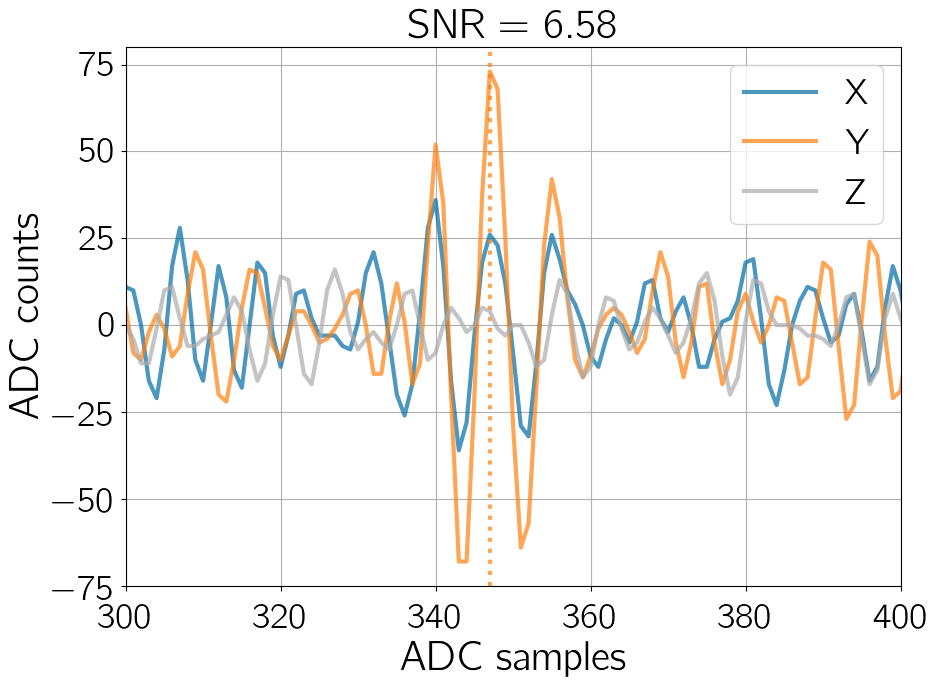

In [17]:
with np.load(SIG_FILE) as sig_file:
    test_idx     = np.where(sig_file['snr']>6)[0][4]
    test_trace   = sig_file['traces'][test_idx]
    test_t_pulse = sig_file['t_pulse'][test_idx]
    test_snr     = sig_file['snr'][test_idx]

# with np.load(BKG_FILE) as bkg_file:
#     test_idx     = 2
#     test_trace   = bkg_file['traces'][test_idx]
#     test_t_pulse = bkg_file['t_pulse'][test_idx]
#     test_snr     = bkg_file['snr'][test_idx]

for ch in [0,1,2]:
    plt.plot(test_trace[ch],color=PLOT_COLORS[ch],alpha=.7,label=f'{POL_TEMPLATE_FLT[ch]}')
    if test_t_pulse[ch] > 100:
        plt.axvline(test_t_pulse[ch],color=PLOT_COLORS[ch],alpha=.7,ls=':')
plt.xlim([300,400])
plt.xlabel('ADC samples')
plt.ylabel('ADC counts')
plt.title(f'SNR = {test_snr:.2f}')
plt.legend(frameon=True)
plt.show()

In [18]:
importlib.reload(flt.v2.template_FLT)
from flt.v2.template_FLT import *

template_FLT = TemplateFLT()
template_FLT.set_sampling_rates(ADC_SAMPLING_RATE,SIM_SAMPLING_RATE)
template_FLT.set_corr_window(CORR_WINDOW)
template_FLT.load_templates(TEMPLATE_FILE_XY)

In [19]:
test_ch = 1
template_FLT.template_fit(test_trace[test_ch],test_t_pulse[test_ch])

plot_title = f'Polarization {["X","Y","Z"][test_ch]}, SNR = {test_snr:.2f}'

In [20]:
corr_window_start, corr_vals_window = template_FLT._cross_corr_desampled(test_trace[test_ch],test_t_pulse[test_ch])

t_corr                = np.arange(corr_window_start,corr_window_start+corr_vals_window.shape[-1])
corr_vals_window_best = corr_vals_window[template_FLT.idx_template_best_fit,template_FLT.idx_templates_desampled_best[template_FLT.idx_template_best_fit]]

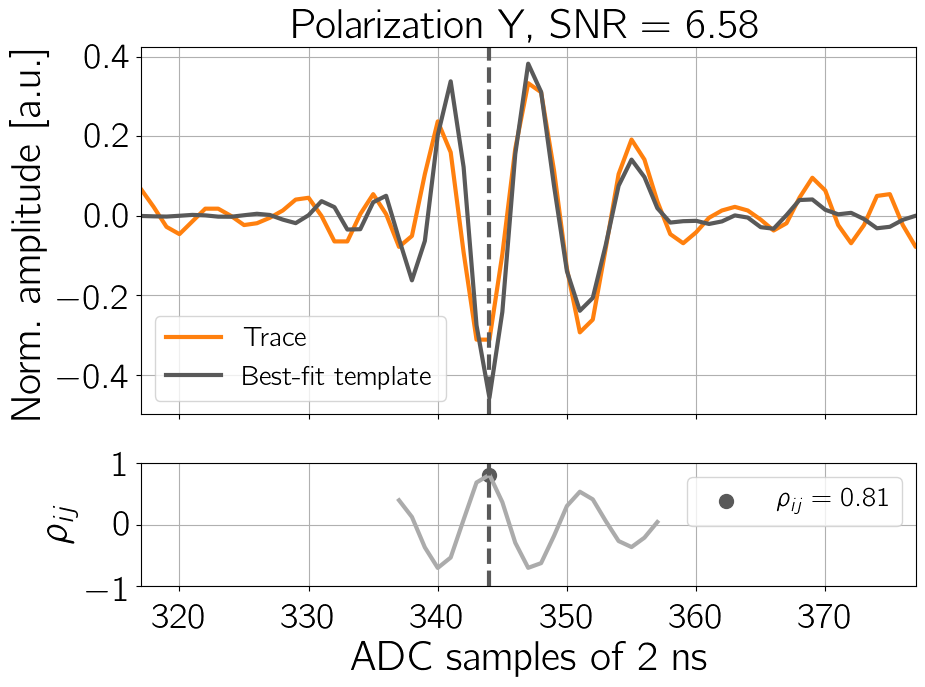

In [21]:
template_best = template_FLT.templates[template_FLT.idx_template_best_fit]
time_best     = template_FLT.time_best[template_FLT.idx_template_best_fit]
corr_best     = template_FLT.ts

t_template = np.arange(time_best-30,time_best-30+template_best.shape[0],dtype=int)

norm_test_trace = np.linalg.norm(test_trace[test_ch,t_template])


fig, ax = plt.subplots(2,1,sharex=True,height_ratios=[3,1])

ax[0].plot(test_trace[test_ch]/norm_test_trace,color=PLOT_COLORS[1],label='Trace')
ax[0].plot(t_template,-template_best,color=PLOT_COLORS[3],label='Best-fit template')

ax[1].plot(t_corr,-corr_vals_window_best,color=PLOT_COLORS[2])
ax[1].scatter(time_best,corr_best,color=PLOT_COLORS[3],marker='o',s=100,label=rf'$\rho_{{ij}} = {corr_best:.2f}$')

ax[0].axvline(time_best,color=PLOT_COLORS[3],ls='--')
ax[1].axvline(time_best,color=PLOT_COLORS[3],ls='--')

ax[0].set_xlim([t_corr[0]-20,t_corr[-1]+20])
ax[1].set_ylim([-1,1])

ax[0].set_ylabel('Norm.~amplitude [a.u.]')
ax[1].set_ylabel(r'$\rho_{ij}$')
ax[1].set_xlabel('ADC samples of 2 ns')

ax[0].legend(frameon=True,fontsize=20)
ax[1].legend(frameon=True,fontsize=20)

ax[0].set_title(plot_title)

#plt.suptitle('Correlation scan')

plt.show()

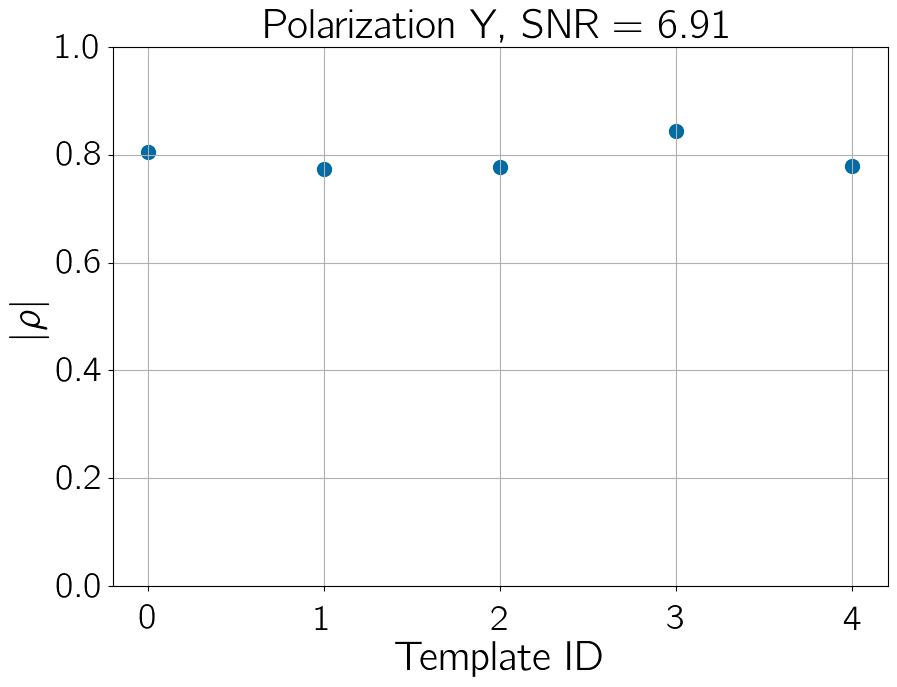

In [96]:
fig, ax = plt.subplots()

ax.scatter(np.arange(template_FLT.n_templates),np.abs(template_FLT.corr_best),s=100)

ax.set_ylim([0,1])

ax.set_xlabel('Template ID')
ax.set_ylabel(r'$|\rho|$')

ax.set_title(plot_title)

plt.show()

In [8]:
test_trace

array([[ 0,  0,  0, ...,  0, -2,  3],
       [ 0,  0,  0, ..., -5, -4, -5],
       [ 0,  0,  0, ..., 12,  7, -7]])